#**Analitica para ultimo sprint - PI.**

En este colab se encuentran los codigos utilizados para el desarrollo de la parte analitica del Sprin. Más concretamente, las funciones para sacar la **Fast Fourier Transformation (FFT)** y los indicadores de **Energia total**, **Frecuencias activas** y **Autocorrelacion Sesgada (Normalizada)**.

##**Generación de medición arritmica**

Este codigo genera un JSON que contiene datos para simular una señal arritmica, caracteristica esperada de los pacientes con parkinson.

In [14]:
import json
import numpy as np


# Función para generar una señal asincrónica
def generate_asynchronous_signal(samples):
    timestamps = np.linspace(0, samples / 25, samples)  # Simular a 25 Hz
    signal = np.random.normal(0, 0.5, samples) + 0.2 * np.sin(2 * np.pi * 0.5 * timestamps)  # Ruido + patrón débil
    data = [{"x": val, "y": 0.0, "z": 0.0, "timestamp": ts}
            for val, ts in zip(signal, timestamps)]
    return data

asynchronous_data = generate_asynchronous_signal(210)

with open('asynchronous.json', 'w') as async_file:
    json.dump({"accelerometer": asynchronous_data}, async_file, indent=4)


##**Matemática general**

En este codigo se dfine la funcion para calcular la autocorrelación, ademas se define la funcion analyze_signal donde se hace todo el proceso; ahí también se calcula la energia total y las frecuencias dominantes, junto con los plots de las graficas correspondientes.

Antes que nada, se da una definicion de autocorrelación, energia total y frecuencias dominantes, asi como una explicacion de como nos pueden servir de indicadores.

###**Energia total.**

La energia total de una señal se calcula a partir de la fft e indica la intesidad global del movimiento capturado por el MPU6050.

Una mayor energia total representaría movimientos más bruscos, en caso del taconeo o zapateo, que se está ejerciendo bastante fuerza. Esto nos podría dar información sobre temblores más intensos.

Si hay una energia total menor, se puede decir que para el caso de estudio representaria algun tipo de fatiga, ya que se está dando movimientos más suaves y controlados.

###**Frecuencias activas.**

El rango de frecuencias activas nos indica donde se concentra un procentaje x de la energia. En este caso, elegimos el 90%.

Un paciente con parkinson podria tener un rango más irregular o amplio debido a temblores.

###Autocorrelación.

La autocorrelacion sesgada mide como una funcion en el tiempo es igual asi misma a diferentes retrasos (lags) mediante una funcion "espejo". Los picos de la grafica de autocorrleación representan en que medida la señal espejo es igual a la señal original.

Se espera que una grafica de autocorrelación para una señal producto de un paciente de parkinson presente irregularidad e uniformidad en los picos dada la falta de ritmo.

--- Resultados para Señal Asincronizada ---
Energía total: 5855.5086
Rango de frecuencias activas: 0.47 Hz - 11.02 Hz


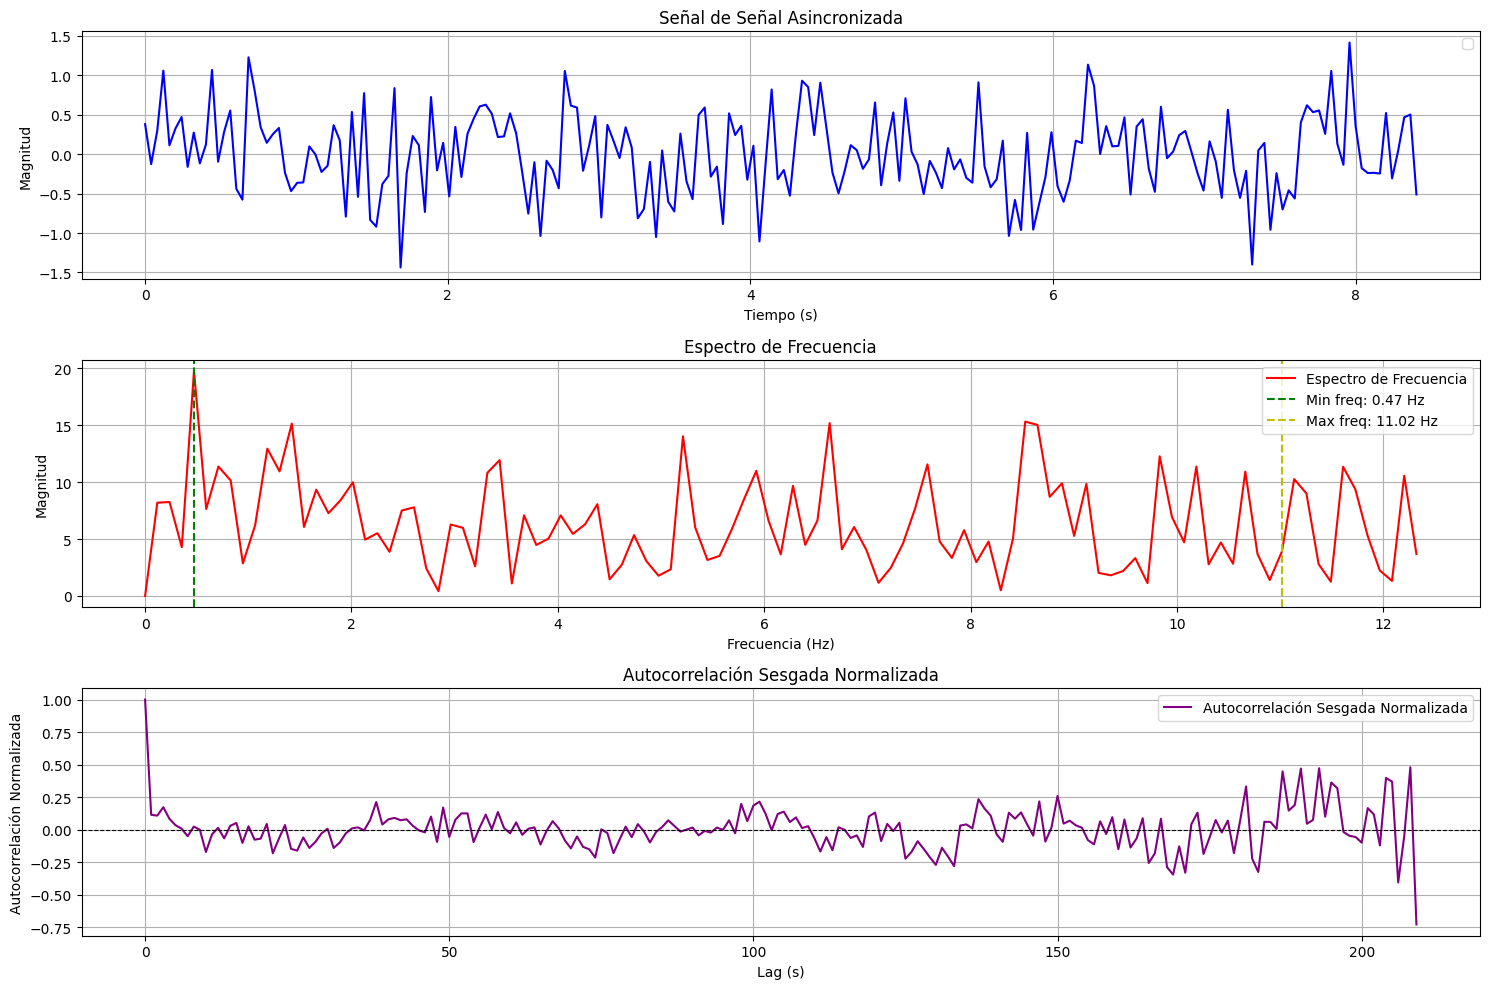

In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def load_signal(filename):

    with open(filename, 'r') as file:
        data = json.load(file)
    accelerometer_data = data["accelerometer"]
    timestamps = [point["timestamp"] for point in accelerometer_data]
    x_values = [point["x"] for point in accelerometer_data]
    return np.array(timestamps), np.array(x_values)

def unbiased_autocorrelation_normalized(signal):

    N = len(signal)
    autocorr = np.correlate(signal, signal, mode='full')  # Autocorrelación
    lags = np.arange(-N + 1, N)
    normalization = np.array([N - abs(lag) for lag in lags])  # Factor de normalización
    unbiased_autocorr = autocorr / normalization

    unbiased_autocorr_normalized = unbiased_autocorr / unbiased_autocorr[N - 1]
    return lags, unbiased_autocorr_normalized

def analyze_signal(filename, label):


    timestamps, magnitudes = load_signal(filename)
    time = np.array(timestamps)
    time -= np.min(time)


    detrended_magnitudes = magnitudes - np.mean(magnitudes)

    # Calcular la FFT
    n = len(detrended_magnitudes)
    frequencies = fftfreq(n, (time[1] - time[0]))
    fft_values = fft(detrended_magnitudes)

    # Magnitud de la FFT (Positiva)
    positive_freqs = frequencies[:n//2]
    positive_fft_values = np.abs(fft_values[:n//2])

    # Energía total
    energy_total = np.sum(positive_fft_values**2)

    # Rango de frecuencias activas (al menos 90% de la energía)
    cumulative_energy = np.cumsum(positive_fft_values**2)
    threshold = 0.9 * energy_total
    min_freq = positive_freqs[np.where(cumulative_energy >= 0.05 * energy_total)[0][0]]
    max_freq = positive_freqs[np.where(cumulative_energy >= threshold)[0][0]]


    lags, autocorr_normalized = unbiased_autocorrelation_normalized(detrended_magnitudes)


    positive_lags = lags[lags >= 0]
    positive_autocorr = autocorr_normalized[lags >= 0]


    print(f"--- Resultados para {label} ---")
    print(f"Energía total: {energy_total:.4f}")
    print(f"Rango de frecuencias activas: {min_freq:.2f} Hz - {max_freq:.2f} Hz")


    plt.figure(figsize=(15, 10))

    # Señal original
    plt.subplot(3, 1, 1)
    plt.plot(time, detrended_magnitudes, color="b")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Magnitud")
    plt.title(f"Señal de {label}")
    plt.grid(True)
    plt.legend()

    # FFT
    plt.subplot(3, 1, 2)
    plt.plot(positive_freqs, positive_fft_values, label="Espectro de Frecuencia", color="r")
    plt.axvline(min_freq, color='g', linestyle='--', label=f'Min freq: {min_freq:.2f} Hz')
    plt.axvline(max_freq, color='y', linestyle='--', label=f'Max freq: {max_freq:.2f} Hz')
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    plt.title(f"Espectro de Frecuencia")
    plt.grid(True)
    plt.legend()

    # Autocorrelación normalizada
    plt.subplot(3, 1, 3)
    plt.plot(positive_lags, positive_autocorr, label="Autocorrelación Sesgada Normalizada", color="purple")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.xlabel("Lag (s)")
    plt.ylabel("Autocorrelación Normalizada")
    plt.title("Autocorrelación Sesgada Normalizada")
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()



analyze_signal('asynchronous.json', 'Señal Asincronizada')